
---
*
*
*
*
*
*
*
*
*
*
IMPORTANTE: hay final, despues de que se muetran los modelos de cajas hay que aplicar criterios de hipotesis
eso se dio en la clase, en los cuadernos hay un ejemplo
-
-
-
-
-----

In [1]:
#esto es una prueba
import numpy as np
import time
from datetime import datetime
import pandas as pd
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical

from skimage import feature
from skimage.io import imread
from skimage.color import rgb2gray

from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

hora_actual = []
now = datetime.now() # current date and time
hora_actual.append(now.strftime("%d/%m/%Y %H:%M:%S"))


/tmp/ipykernel_335670/1198335902.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'cv2'

In [2]:
# Install Kaggle package
!pip install kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

ModuleNotFoundError: No module named 'google'

In [4]:
# Copiar el archivo json en ~/.kaggle porque así lo requiere el API de Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Cambio de permisos para evitar warning de la herramienta de kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Descarga del dataset sujaykapadnis/emotion-recognition-dataset
# sujaykapadnis: nombre del usuario que tiene el dataset
# emotion-recognition-dataset: nombre del dataset
# Desde kaggle se puede copiar este comando

!kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset


emotion-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
# Unzip de los archivos
!unzip -q emotion-recognition-dataset.zip

replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [48]:
def load_data(path):
    X, y = [], []
    #1205 es la menor cantidad de img en cada clase
    #En este caso solo se consideran 3740 img
    # de cada clase debido a que es la clase que menos imagenes posee
    for label in CLASSES:
        for img in os.listdir(os.path.join(path, label))[:100]: # OJO for img in os.listdir(os.path.join(path, label))[:1466]:
            full_path = os.path.join(path, label, img)
            image = cv2.imread(full_path)
            image = cv2.resize(image, SIZE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = np.asarray(image).astype(np.float32) / 255.0
            X.append(image)
            y.append(CLASSES.index(label))

    y = to_categorical(y, num_classes=NUM_CLASSES)
    y = np.argmax(y, axis=1)
    return np.array(X), np.array(y)


In [50]:
TRAIN_PATH = './dataset'
SIZE = (112, 112)
CLASSES = []
#CLASSES = ['Happy','Neutral','Sad']
for class_ in os.listdir(TRAIN_PATH):
    CLASSES.append(class_)
NUM_CLASSES = len(CLASSES)
print(CLASSES)

['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [51]:
X_train, y_train = load_data(TRAIN_PATH)
cant_imag , ancho, alto = X_train.shape

In [52]:
vectores_hog=[]
for i in range(cant_imag):
    vector_caracteristicas = feature.hog(X_train[i], feature_vector=True)
    vectores_hog.append(vector_caracteristicas)
vectores_hog = np.array(vectores_hog)

In [55]:
def calculate_metrics(classifier, X_train, y_train, cv):
    scoring = ['accuracy','precision_macro', 'recall_macro', 'precision_micro', 'recall_micro', 'f1_macro']
    scores = cross_validate(classifier, X_train, y_train, cv=20, scoring=scoring)
    mean_accuracy = np.mean(scores['test_accuracy'])
    mean_precision_macro = np.mean(scores['test_precision_macro'])
    mean_recall_macro = np.mean(scores['test_recall_macro'])
    mean_precision_micro = np.mean(scores['test_precision_micro'])
    mean_recall_micro = np.mean(scores['test_recall_micro'])
    mean_f1_macro = np.mean(scores['test_f1_macro'])

    metrics_dict = {
        'accuracy'          : mean_accuracy,
        'precision_macro'   : mean_precision_macro,
        'recall_macro'      : mean_recall_macro,
        'precision_micro'   : mean_precision_micro,
        'recall_micro'      : mean_recall_micro,
        'f1_macro'          : mean_f1_macro
    }

    return metrics_dict

In [56]:
def append_data_to_excel(excel_name, df):
    with pd.ExcelWriter(excel_name,
        mode="a",
        engine="openpyxl",
        if_sheet_exists="overlay") as writer:
        start_row = 0
        header = True
        if os.path.exists(excel_name):
            df_source = pd.read_excel(excel_name, engine="openpyxl").iloc[:,1:]
        if df_source is not None:
            n, m = df_source.shape
            header = False if n > 0 else True
            start_row = n + 1 if n > 0 else n

        df.to_excel(writer, sheet_name="Sheet1",startcol=0, startrow = start_row, header=header)

In [57]:
def KNN_model(vectores_hog , y_train):
    #n_neighbors = [1 , 5 , 31 , 61]
    n_neighbors = [1 , 5]
    for k in n_neighbors:
        tic = time.perf_counter()
        knn_model = KNeighborsClassifier(n_neighbors=k)
        metrics_knn = calculate_metrics(knn_model, vectores_hog, y_train, cv=20)
        toc = time.perf_counter()

        data_knn_model = {
            'accuracy'          : metrics_knn['accuracy'],
            'precision_macro'   : metrics_knn['precision_macro'],
            'recall_macro'      : metrics_knn['recall_macro'],
            'precision_micro'   : metrics_knn['precision_micro'],
            'recall_micro'      : metrics_knn['recall_micro'],
            'f1_macro'          : metrics_knn['f1_macro'],
            'tiempo (s)'        : [round((toc-tic), 2)]
        }

        df_knn_model = pd.DataFrame(data_knn_model, index = ["KNN n_neighbors = "+str(k)])
        append_data_to_excel('./Metricas.xlsx', df_knn_model)

        print('Metrics for KNN with k =', k)
        print(metrics_knn)

    return data_knn_model['accuracy']

In [58]:
def LR_model(vectores_hog , y_train):  
    solver = ['lbfgs', 'newton-cg'] 
    for label in solver:
      tic = time.perf_counter()
      LR_model = LogisticRegression(penalty=None, solver = label, max_iter=10000, multi_class='multinomial')
      #LR_model = LogisticRegression(penalty="l1", solver = label, max_iter=5000, multi_class='multinomial')
      metrics_lr = calculate_metrics(LR_model, vectores_hog, y_train, cv=20)
      toc = time.perf_counter()

      data_lr_model = {
          'accuracy'          : metrics_lr['accuracy'],
          'precision_macro'   : metrics_lr['precision_macro'],
          'recall_macro'      : metrics_lr['recall_macro'],
          'precision_micro'   : metrics_lr['precision_micro'],
          'recall_micro'      : metrics_lr['recall_micro'],
          'f1_macro'          : metrics_lr['f1_macro'],
          'tiempo (s)'        : [round((toc-tic), 2)]
      }

      df_lr_model = pd.DataFrame(data_lr_model, index = ["LR con solver = " + label])
      append_data_to_excel('./Metricas.xlsx', df_lr_model)

      print('Metrics for LR model:')
      print(df_lr_model)

    return data_lr_model['accuracy']

In [59]:
def SVM_model(vectores_hog , y_train): 
    #kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
    #kernel = ['linear', 'poly', 'rbf']
    kernel = ['linear', 'poly']
    for label in kernel:
      tic = time.perf_counter()
      svm_model = svm.SVC(kernel=label)
      metrics_svm = calculate_metrics(svm_model, vectores_hog, y_train, cv=20)
      toc = time.perf_counter()
      data_svm_model = {
          'accuracy'          : metrics_svm['accuracy'],
          'precision_macro'   : metrics_svm['precision_macro'],
          'recall_macro'      : metrics_svm['recall_macro'],
          'precision_micro'   : metrics_svm['precision_micro'],
          'recall_micro'      : metrics_svm['recall_micro'],
          'f1_macro'          : metrics_svm['f1_macro'],
          'tiempo (s)'        : [round((toc-tic), 2)]
      }
      df_svm_model = pd.DataFrame(data_svm_model, index = ["SVM para kernel " + label])
      append_data_to_excel('./Metricas.xlsx', df_svm_model)

      print('Metrics for SVM:')
      print(df_svm_model)

    return data_svm_model['accuracy']

In [60]:
def Random_Forest_model(vectores_hog, y_train):
    #estimators = [10, 50, 100, 200]
    estimators = [10, 50]  
    for label in estimators:
        tic = time.perf_counter()
        rf_model = RandomForestClassifier(n_estimators=label)
        metrics_rf = calculate_metrics(rf_model, vectores_hog, y_train, cv=20)
        toc = time.perf_counter()

        data_rf_model = {
            'accuracy'          : metrics_rf['accuracy'],
            'precision_macro'   : metrics_rf['precision_macro'],
            'recall_macro'      : metrics_rf['recall_macro'],
            'precision_micro'   : metrics_rf['precision_micro'],
            'recall_micro'      : metrics_rf['recall_micro'],
            'f1_macro'          : metrics_rf['f1_macro'],
            'tiempo (s)'        : [round((toc-tic), 2)]
        }

        df_rf_model = pd.DataFrame(data_rf_model, index = ["Random Forest n_estimators = "+str(label)])
        append_data_to_excel('./Metricas.xlsx', df_rf_model)

        print('Metrics for Random Forest with n_estimators =', label)
        print(metrics_rf)

    return data_rf_model['accuracy']

In [61]:
print(vectores_hog.shape)

(600, 11664)


In [63]:
accuracy_test_RF = Random_Forest_model(vectores_hog,y_train)

Metrics for Random Forest with n_estimators = 10
{'accuracy': 0.3983333333333333, 'precision_macro': 0.37885341510341514, 'recall_macro': 0.3983333333333334, 'precision_micro': 0.3983333333333333, 'recall_micro': 0.3983333333333333, 'f1_macro': 0.37320231103319335}
Metrics for Random Forest with n_estimators = 50
{'accuracy': 0.5199999999999999, 'precision_macro': 0.5081646825396826, 'recall_macro': 0.5199999999999999, 'precision_micro': 0.5199999999999999, 'recall_micro': 0.5199999999999999, 'f1_macro': 0.5014855977355979}


In [62]:
#DUDA : accuracy, recall_macro ,precision_micro y recall_micro ,me dan exactamente iguales

accuracy_test_KNN = KNN_model(vectores_hog,y_train)


Metrics for KNN with k = 1
{'accuracy': 0.43833333333333335, 'precision_macro': 0.45641023328523334, 'recall_macro': 0.43833333333333335, 'precision_micro': 0.43833333333333335, 'recall_micro': 0.43833333333333335, 'f1_macro': 0.42491670774759005}
Metrics for KNN with k = 5
{'accuracy': 0.45, 'precision_macro': 0.459346718096718, 'recall_macro': 0.45, 'precision_micro': 0.45, 'recall_micro': 0.45, 'f1_macro': 0.4332321382321382}


In [64]:
accuracy_test_SVM = SVM_model(vectores_hog , y_train)


Metrics for SVM:
                        accuracy  precision_macro  recall_macro  \
SVM para kernel linear  0.641667         0.654332      0.641667   

                        precision_micro  recall_micro  f1_macro  tiempo (s)  
SVM para kernel linear         0.641667      0.641667  0.626268      510.53  
Metrics for SVM:
                      accuracy  precision_macro  recall_macro  \
SVM para kernel poly      0.65         0.656382          0.65   

                      precision_micro  recall_micro  f1_macro  tiempo (s)  
SVM para kernel poly             0.65          0.65   0.63744      557.54  


In [65]:
accuracy_test_LR = LR_model(vectores_hog , y_train)

Metrics for LR model:
                       accuracy  precision_macro  recall_macro  \
LR con solver = lbfgs  0.626667          0.65253      0.626667   

                       precision_micro  recall_micro  f1_macro  tiempo (s)  
LR con solver = lbfgs         0.626667      0.626667  0.621166       14.27  
Metrics for LR model:
                           accuracy  precision_macro  recall_macro  \
LR con solver = newton-cg     0.635         0.637597         0.635   

                           precision_micro  recall_micro  f1_macro  tiempo (s)  
LR con solver = newton-cg            0.635         0.635  0.619778       18.03  


In [66]:
print(type(accuracy_test_RF))

<class 'numpy.float64'>


In [67]:
acc_KNN = []
acc_KNN.append(accuracy_test_KNN)
acc_LR = []
acc_LR.append(accuracy_test_LR)
acc_SVM = []
acc_SVM.append(accuracy_test_SVM)
acc_RF =[]
acc_RF.append(accuracy_test_RF)

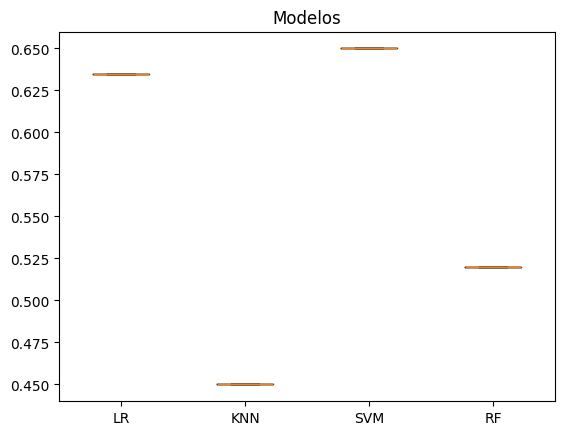

In [68]:
data = [acc_LR, acc_KNN,acc_SVM,acc_RF]
fig7, ax = plt.subplots()
ax.set_title('Modelos')
ax.boxplot(data,labels=['LR','KNN','SVM','RF']);

In [ ]:
#train_time = []

#tic = time.perf_counter()
#ejecucion del codigo
#toc = time.perf_counter()
#train_time.append(round((toc-tic), 2))

